In [1]:
import pandas as pd
import glob
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM

from IPython.display import Image

### Text Classification
#### Data Exploration and Pre-processing

In [2]:
punc = string.punctuation
nums = string.digits
strs = punc+nums+'\n'

sentiment = ['pos', 'neg']
path = r'../data/'

df = pd.DataFrame()

for i in sentiment:
    
    contents = []
    mod_contents = []
    content_lists = []
    mod_content_lists = []
    sentiments = []
    file_names = []
    cv_nums = []
    review_lengths = []
    
    txt_list = glob.glob(path + i + "/*.txt")
    df_temp = pd.DataFrame()
    
    for file_name in txt_list:
        my_file = open(file_name, 'r')
        content = my_file.read()
        content_list = content.split(' ')
        my_file.close()
        
        test_str = content
        
        for a in test_str:
            if a in strs:
                test_str = test_str.replace(a, '')
                
        test_str = " ".join(test_str.split())
        
        mod_content_list = test_str.split(' ')
        
        contents.append(content)
        mod_contents.append(test_str)
        content_lists.append(content_list)
        mod_content_lists.append(mod_content_list)
        sentiments.append(i)
        file_names.append(str(file_name.split('/')[-1:][0][:-4]))
        cv_nums.append(int(file_name.split('/')[-1:][0][2:5]))
        review_lengths.append(len(mod_content_list))
    
    df_temp = pd.DataFrame().assign(contents=contents,
                                    content_lists=content_lists,
                                    sentiments=sentiments,
                                    file_names=file_names,
                                    cv_nums=cv_nums,
                                    mod_contents=mod_contents,
                                    mod_content_lists=mod_content_lists,
                                    review_lengths=review_lengths)
    
    df = pd.concat([df, df_temp])

In [3]:
df['y'] = np.where(df['sentiments']=='pos',1,-1)
df['sets'] = np.where(df['cv_nums']<700,'training','testing')
df = df.reset_index(drop=True)

In [4]:
df.head()

,contents,content_lists,sentiments,file_names,cv_nums,mod_contents,mod_content_lists,review_lengths,y,sets
0,assume nothing . \nthe phrase is perhaps one o...,"[assume, nothing, ., \nthe, phrase, is, perhap...",pos,cv839_21467,839,assume nothing the phrase is perhaps one of th...,"[assume, nothing, the, phrase, is, perhaps, on...",790,1,testing
1,plot : derek zoolander is a male model . \nhe ...,"[plot, :, derek, zoolander, is, a, male, model...",pos,cv034_29647,34,plot derek zoolander is a male model he is als...,"[plot, derek, zoolander, is, a, male, model, h...",616,1,training
2,i actually am a fan of the original 1961 or so...,"[i, actually, am, a, fan, of, the, original, 1...",pos,cv908_16009,908,i actually am a fan of the original or so live...,"[i, actually, am, a, fan, of, the, original, o...",1589,1,testing
3,a movie that's been as highly built up as the ...,"[a, movie, that's, been, as, highly, built, up...",pos,cv748_12786,748,a movie thats been as highly built up as the t...,"[a, movie, thats, been, as, highly, built, up,...",423,1,testing
4,""" good will hunting "" is two movies in one : ...","[, "", good, will, hunting, "", is, two, movies,...",pos,cv253_10077,253,good will hunting is two movies in one an inde...,"[good, will, hunting, is, two, movies, in, one...",278,1,training


---

In [5]:
unique_words = []

for i in range(len(df)):
    unique_words += df['mod_content_lists'].iloc[i]

In [6]:
print('There are', len(Counter(unique_words).most_common()), 'unique words, and the number of them shows as below:')

There are 46830 unique words, and the number of them shows as below:


In [7]:
Counter(unique_words).most_common()

[('the', 76327),
 ('a', 37964),
 ('and', 35351),
 ('of', 33971),
 ('to', 31763),
 ('is', 25179),
 ('in', 21598),
 ('that', 15112),
 ('it', 12301),
 ('as', 11343),
 ('with', 10779),
 ('for', 9914),
 ('his', 9569),
 ('this', 9565),
 ('film', 8861),
 ('but', 8584),
 ('he', 7611),
 ('i', 7504),
 ('on', 7249),
 ('are', 6945),
 ('by', 6218),
 ('be', 6082),
 ('its', 5987),
 ('an', 5736),
 ('not', 5527),
 ('one', 5521),
 ('movie', 5440),
 ('who', 5378),
 ('from', 4986),
 ('at', 4965),
 ('was', 4934),
 ('have', 4899),
 ('has', 4715),
 ('her', 4504),
 ('you', 4437),
 ('they', 4278),
 ('all', 4251),
 ('so', 3584),
 ('like', 3554),
 ('about', 3518),
 ('out', 3441),
 ('more', 3345),
 ('when', 3254),
 ('which', 3155),
 ('their', 3116),
 ('up', 3107),
 ('or', 3097),
 ('what', 3078),
 ('some', 2982),
 ('just', 2900),
 ('if', 2791),
 ('there', 2758),
 ('she', 2687),
 ('him', 2631),
 ('into', 2617),
 ('even', 2555),
 ('only', 2483),
 ('than', 2438),
 ('no', 2413),
 ('we', 2360),
 ('good', 2321),
 ('most

---

In [8]:
print('The average review length is %f.' %df['review_lengths'].mean())

The average review length is 644.355500.


In [9]:
print('The standard deviation of review lengths is %f.' %df['review_lengths'].std())

The standard deviation of review lengths is 285.051143.


---

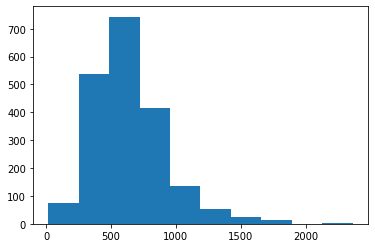

In [10]:
plt.hist(df['review_lengths'])
plt.show()

---

In [11]:
# References
# Tokenizer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://stackoverflow.com/questions/67150848/getting-the-number-of-words-from-tf-tokenizer-after-fitting

In [12]:
# sum([x for _,x in t.word_counts.items()])

In [13]:
tokenizer = Tokenizer()

untokened_seq = ''

for i in range(len(df)):
    untokened_seq += df['contents'].iloc[i]
    
tokenizer.fit_on_texts([untokened_seq])

In [14]:
token_list = []

for i in range(len(df)):
    token_list.append(tokenizer.texts_to_sequences([df.iloc[i,0]])[0])

In [15]:
df['tokenized']=pd.DataFrame([token_list]).T

In [16]:
df[['contents','tokenized']].head()

,contents,tokenized
0,assume nothing . \nthe phrase is perhaps one o...,"[2562, 184, 1, 4341, 6, 297, 23, 4, 1, 63, 378..."
1,plot : derek zoolander is a male model . \nhe ...,"[97, 2372, 8317, 6, 2, 1259, 1878, 17, 6, 71, ..."
2,i actually am a fan of the original 1961 or so...,"[18, 176, 718, 2, 910, 4, 1, 206, 12164, 46, 3..."
3,a movie that's been as highly built up as the ...,"[2, 26, 191, 69, 10, 1027, 1962, 42, 10, 1, 10..."
4,""" good will hunting "" is two movies in one : ...","[61, 66, 1930, 6, 76, 121, 7, 23, 24, 2929, 15..."


---

In [17]:
L = int(df['review_lengths'].quantile(.7))
print('The review length L is %d.' %L)

The review length L is 737.


---

In [18]:
# References
# pad_sequence: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [19]:
padded = pad_sequences(df['tokenized'],maxlen=L)
print(padded.shape)

(2000, 737)


In [20]:
pad_list = []

for i in range(len(df)):
    pad_list.append(padded[i])

In [21]:
df['padded']=pad_list

In [22]:
df.head()

,contents,content_lists,sentiments,file_names,cv_nums,mod_contents,mod_content_lists,review_lengths,y,sets,tokenized,padded
0,assume nothing . \nthe phrase is perhaps one o...,"[assume, nothing, ., \nthe, phrase, is, perhap...",pos,cv839_21467,839,assume nothing the phrase is perhaps one of th...,"[assume, nothing, the, phrase, is, perhaps, on...",790,1,testing,"[2562, 184, 1, 4341, 6, 297, 23, 4, 1, 63, 378...","[3863, 3763, 2245, 360, 8853, 269, 11, 6792, 1..."
1,plot : derek zoolander is a male model . \nhe ...,"[plot, :, derek, zoolander, is, a, male, model...",pos,cv034_29647,34,plot derek zoolander is a male model he is als...,"[plot, derek, zoolander, is, a, male, model, h...",616,1,training,"[97, 2372, 8317, 6, 2, 1259, 1878, 17, 6, 71, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,i actually am a fan of the original 1961 or so...,"[i, actually, am, a, fan, of, the, original, 1...",pos,cv908_16009,908,i actually am a fan of the original or so live...,"[i, actually, am, a, fan, of, the, original, o...",1589,1,testing,"[18, 176, 718, 2, 910, 4, 1, 206, 12164, 46, 3...","[85, 36, 178, 35, 88, 763, 3, 20, 1169, 7, 233..."
3,a movie that's been as highly built up as the ...,"[a, movie, that's, been, as, highly, built, up...",pos,cv748_12786,748,a movie thats been as highly built up as the t...,"[a, movie, thats, been, as, highly, built, up,...",423,1,testing,"[2, 26, 191, 69, 10, 1027, 1962, 42, 10, 1, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,""" good will hunting "" is two movies in one : ...","[, "", good, will, hunting, "", is, two, movies,...",pos,cv253_10077,253,good will hunting is two movies in one an inde...,"[good, will, hunting, is, two, movies, in, one...",278,1,training,"[61, 66, 1930, 6, 76, 121, 7, 23, 24, 2929, 15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


---

#### Word Embeddings

In [23]:
# References
# Word Embeddings: https://www.tensorflow.org/text/guide/word_embeddings
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# https://stackoverflow.com/questions/51699001/tokenizer-texts-to-sequences-keras-tokenizer-gives-almost-all-zeros

In [24]:
# Repeat the steps above using Training Sets only

# Tokenizer fits on training sets
tokenizer = Tokenizer()
untokened_seq = ''
token_list = []
pad_list = []

for i in range(len(df[df['sets']=='training'])):
    untokened_seq += df[df['sets']=='training'].iloc[i,0]
    
tokenizer.fit_on_texts([untokened_seq])

# update df tokenized column
for i in range(len(df)):
    token_list.append(tokenizer.texts_to_sequences([df.iloc[i,0]])[0])

df['tokenized'] = pd.DataFrame([token_list]).T

# update df paddaed column
padded = pad_sequences(df['tokenized'],maxlen=L)

for i in range(len(df)):
    pad_list.append(padded[i])

df['padded'] = pad_list

In [25]:
embed = np.where(padded>5000,0,padded)

In [26]:
embed_list = []

for i in range(len(df)):
    embed_list.append(embed[i])

In [27]:
df['embed'] = embed_list

In [28]:
df[df['sets']=='training'].head()

,contents,content_lists,sentiments,file_names,cv_nums,mod_contents,mod_content_lists,review_lengths,y,sets,tokenized,padded,embed
1,plot : derek zoolander is a male model . \nhe ...,"[plot, :, derek, zoolander, is, a, male, model...",pos,cv034_29647,34,plot derek zoolander is a male model he is als...,"[plot, derek, zoolander, is, a, male, model, h...",616,1,training,"[93, 3964, 10816, 6, 2, 1218, 2782, 17, 6, 72,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,""" good will hunting "" is two movies in one : ...","[, "", good, will, hunting, "", is, two, movies,...",pos,cv253_10077,253,good will hunting is two movies in one an inde...,"[good, will, hunting, is, two, movies, in, one...",278,1,training,"[61, 66, 1878, 6, 78, 126, 7, 23, 24, 2872, 16...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"the story of us , a rob reiner film , is the s...","[the, story, of, us, ,, a, rob, reiner, film, ...",pos,cv147_21193,147,the story of us a rob reiner film is the secon...,"[the, story, of, us, a, rob, reiner, film, is,...",839,1,training,"[1, 67, 4, 138, 2, 1376, 10822, 15, 6, 1, 320,...","[4510, 3229, 8836, 3451, 3, 1256, 1, 510, 65, ...","[4510, 3229, 0, 3451, 3, 1256, 1, 510, 65, 2, ..."
7,""" the fighting sullivans "" contains a major p...","[, "", the, fighting, sullivans, "", contains, a...",pos,cv686_13900,686,the fighting sullivans contains a major plot d...,"[the, fighting, sullivans, contains, a, major,...",256,1,training,"[1, 1303, 17404, 1205, 2, 443, 93, 1188, 7, 1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,george little ( jonathan lipnicki ) wants a li...,"[george, little, (, jonathan, lipnicki, ), wan...",pos,cv410_24266,410,george little jonathan lipnicki wants a little...,"[george, little, jonathan, lipnicki, wants, a,...",960,1,training,"[612, 92, 1762, 14281, 299, 2, 92, 590, 83, 42...","[100, 102, 3, 56, 1, 3124, 4, 1, 23, 1812, 111...","[100, 102, 3, 56, 1, 3124, 4, 1, 23, 1812, 111..."


In [29]:
X_train = np.stack((df[df['sets']=='training']['embed']))
X_test = np.stack((df[df['sets']=='testing']['embed']))

In [30]:
y_train = df[df['sets']=='training']['y']
y_train = np.where(y_train<0,0,1)
y_test = df[df['sets']=='testing']['y']
y_test = np.where(y_test<0,0,1)

In [31]:
top_words = 5001
max_words = L

model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 737, 32)           160032    
                                                                 
Total params: 160,032
Trainable params: 160,032
Non-trainable params: 0
_________________________________________________________________
None


---

In [32]:
model.add(Flatten())
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 737, 32)           160032    
                                                                 
 flatten (Flatten)           (None, 23584)             0         
                                                                 
Total params: 160,032
Trainable params: 160,032
Non-trainable params: 0
_________________________________________________________________
None


---

#### Multi-Layer Perceptron

In [33]:
# References
# ReLu: https://keras.io/api/layers/activations/

In [34]:
model.add(Dense(50, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 737, 32)           160032    
                                                                 
 flatten (Flatten)           (None, 23584)             0         
                                                                 
 dense (Dense)               (None, 50)                1179250   
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2

In [35]:
model.fit(X_train, y_train, epochs=2, batch_size=10)

Epoch 1/2
140/140 [==============================] - 2s 7ms/step - loss: 0.6962 - accuracy: 0.5043
Epoch 2/2
140/140 [==============================] - 1s 7ms/step - loss: 0.6561 - accuracy: 0.6257


---

In [36]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('MLP model | Train Accuracy: %f | Test Accuracy: %f' %(train_accuracy, test_accuracy))

MLP model | Train Accuracy: 0.917143 | Test Accuracy: 0.560000


---

#### One-Dimensional Convolutional Neural Network

In [37]:
# References
# Conv1D: https://keras.io/api/layers/convolution_layers/convolution1d/
# MaxPooling1D: https://keras.io/api/layers/pooling_layers/max_pooling1d/
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [38]:
model_Conv1D = Sequential()
model_Conv1D.add(Embedding(top_words, 32, input_length=max_words))
model_Conv1D.add(Conv1D(filters=32, kernel_size=3))
model_Conv1D.add(MaxPooling1D(pool_size=2, strides=2))
model_Conv1D.add(Flatten())
model_Conv1D.add(Dense(50, activation='relu'))
model_Conv1D.add(Dropout(rate=0.2))
model_Conv1D.add(Dense(50, activation='relu'))
model_Conv1D.add(Dropout(rate=0.5))
model_Conv1D.add(Dense(50, activation='relu'))
model_Conv1D.add(Dropout(rate=0.5))
model_Conv1D.add(Dense(1, activation='sigmoid'))
model_Conv1D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model_Conv1D.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 737, 32)           160032    
                                                                 
 conv1d (Conv1D)             (None, 735, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 367, 32)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 11744)             0         
                                                                 
 dense_4 (Dense)             (None, 50)                587250    
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [39]:
model_Conv1D.fit(X_train, y_train, epochs=2, batch_size=10)

Epoch 1/2
140/140 [==============================] - 2s 9ms/step - loss: 0.6975 - accuracy: 0.4929
Epoch 2/2
140/140 [==============================] - 1s 9ms/step - loss: 0.6765 - accuracy: 0.5900


---

In [40]:
train_loss, train_accuracy = model_Conv1D.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_Conv1D.evaluate(X_test, y_test, verbose=0)
print('Conv1D model | Train Accuracy: %f | Test Accuracy: %f' %(train_accuracy, test_accuracy))

Conv1D model | Train Accuracy: 0.790714 | Test Accuracy: 0.650000


---

#### Long Short-Term Memory Recurrent Neural Network

In [41]:
# References
# LSTM: https://keras.io/api/layers/recurrent_layers/lstm/
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [42]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(top_words, 32, input_length=max_words))
model_LSTM.add(LSTM(32, dropout=0.2))
model_LSTM.add(Dense(256, activation='relu'))
model_LSTM.add(Dropout(rate=0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model_LSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 737, 32)           160032    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 256)               8448      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 177,057
Trainable params: 177,057
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
model_LSTM.fit(X_train, y_train, epochs=10, batch_size=10)

Epoch 1/10
140/140 [==============================] - 19s 123ms/step - loss: 0.6935 - accuracy: 0.4900
Epoch 2/10
140/140 [==============================] - 17s 122ms/step - loss: 0.5747 - accuracy: 0.7150
Epoch 3/10
140/140 [==============================] - 17s 124ms/step - loss: 0.2444 - accuracy: 0.9029
Epoch 4/10
140/140 [==============================] - 18s 126ms/step - loss: 0.0652 - accuracy: 0.9800
Epoch 5/10
140/140 [==============================] - 17s 123ms/step - loss: 0.0308 - accuracy: 0.9900
Epoch 6/10
140/140 [==============================] - 17s 123ms/step - loss: 0.0334 - accuracy: 0.9871
Epoch 7/10
140/140 [==============================] - 17s 122ms/step - loss: 0.0263 - accuracy: 0.9907
Epoch 8/10
140/140 [==============================] - 18s 126ms/step - loss: 0.0175 - accuracy: 0.9950
Epoch 9/10
140/140 [==============================] - 17s 123ms/step - loss: 0.0078 - accuracy: 0.9979
Epoch 10/10
140/140 [==============================] - 17s 124ms/step - l

---

In [44]:
train_loss, train_accuracy = model_LSTM.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_LSTM.evaluate(X_test, y_test, verbose=0)
print('LSTM model (10 epochs) | Train Accuracy: %f | Test Accuracy: %f' %(train_accuracy, test_accuracy))

LSTM model (10 epochs) | Train Accuracy: 1.000000 | Test Accuracy: 0.730000


In [45]:
for i in range(4):
    model_LSTM.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0)
    train_loss, train_accuracy = model_LSTM.evaluate(X_train, y_train, verbose=0)
    test_loss, test_accuracy = model_LSTM.evaluate(X_test, y_test, verbose=0)
    print('LSTM model (%d0 epochs) | Train Accuracy: %f | Test Accuracy: %f' %(i+2, train_accuracy, test_accuracy))

LSTM model (20 epochs) | Train Accuracy: 1.000000 | Test Accuracy: 0.731667
LSTM model (30 epochs) | Train Accuracy: 1.000000 | Test Accuracy: 0.735000
LSTM model (40 epochs) | Train Accuracy: 1.000000 | Test Accuracy: 0.735000
LSTM model (50 epochs) | Train Accuracy: 1.000000 | Test Accuracy: 0.738333


---

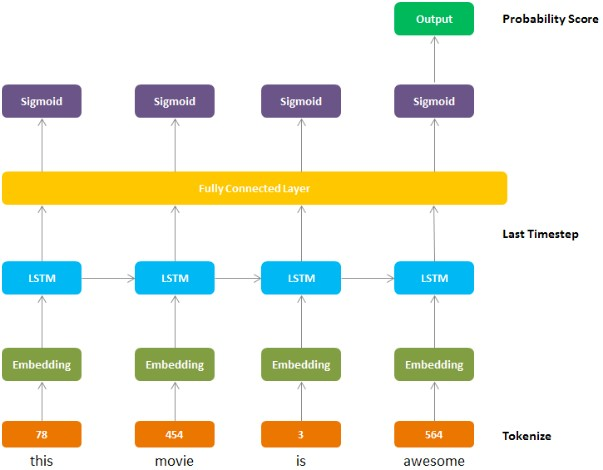

---